In [75]:
#################################################################
# 0. Libraries

import pandas as pd
import numpy as np
import os
import glob

from tqdm import tqdm
from sklearn.preprocessing import normalize

import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import class_weight

import albumentations
from albumentations.core.transforms_interface import ImageOnlyTransform
import cv2
from functools import partial, reduce
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_error


np.random.seed(12)

#################################################################

In [78]:
#################################################################
# 1. Global Variables & Paths

PATH = '../01_Data/'
PATH_MODELS = '../03_Models/'
PATH_SUBMISSIONS = '../04_Submissions/'

path_submissions_me = PATH_SUBMISSIONS + 'Phase 2/'
path_submissions_public = PATH_SUBMISSIONS + 'Best Publics/'

df_labels = pd.concat([
    pd.read_csv(PATH + 'train_labels.csv'),
]).reset_index(drop=True)

df_sample_sub = pd.read_csv(PATH + 'sample_submission.csv')
print(df_labels['target'].value_counts()/len(df_labels))

list_paths_train = glob.glob(PATH + 'train/' + '*/*.npy')
list_paths_test = glob.glob(PATH + 'test/' + '*/*.npy')

print(f'{len(list_paths_train)} train paths, {len(list_paths_test)} test paths')

dict_paths_train = {path.split('\\')[-1].split('.npy')[0] : path for path in list_paths_train}
dict_paths_test = {path.split('\\')[-1].split('.npy')[0] : path for path in list_paths_test}

df_labels['path'] = df_labels['id'].apply(lambda x : dict_paths_train[x])
df_sample_sub['path'] = df_sample_sub['id'].apply(lambda x : dict_paths_test[x])

list_records = df_labels[['id', 'target']].to_dict('records')
dict_paths_labels_train = {elem['id'] : elem['target'] for elem in list_records}

IMG_SIZE = (380, 380, 3)

#################################################################

0    0.9
1    0.1
Name: target, dtype: float64
60000 train paths, 39995 test paths


In [79]:
#################################################################
# 2. Functions

def plotCadence(file_id, target=True):
    if target:
        label = df_labels['target'][df_labels['id']==os.path.basename(file_id).split('.')[0]].values[0]
    else:
        label = None
    img = np.load(file_id).astype(np.float32)
    plt.figure(figsize=(16, 10))
    for i in range(6):
        plt.subplot(6, 1, i + 1)
        if i == 0:
            plt.title(f"ID: {os.path.basename(file_id)} TARGET: {label}", fontsize=18)
        plt.imshow(img[i], interpolation='nearest', aspect='auto')
        plt.text(5, 100, ["ON", "OFF"][i % 2], bbox={'facecolor': 'white'})
    plt.show()
    
    
def buildLoader(labels=True):
    def decode(path):
        file_bytes = tf.io.read_file(path)
        img = tf.io.decode_raw(file_bytes, tf.float16)
        img = tf.reshape(img[64:], [6, 273, 256]) # 419328 = 6 * 273 * 256
        img = tf.cast(img, tf.float32)
        return img
    
    def decodeWithLabels(path, label):
        img = decode(path)
        return img, label
    
    if labels:
        return decodeWithLabels
    else:
        return decode
    
    
def normalizeImage(data, label):
    list_img_norm = []
    for i in range(6):
        img = data[i]
        img -= tf.reduce_mean(img)
        img /= tf.math.reduce_std(img)
        list_img_norm.append(img)
    img_norm = tf.cast(tf.stack(list_img_norm, axis=0), tf.float32)
    return img_norm, label
    
    
def preprocessImage(img, label):
    img_on = tf.concat([img[0], img[2], img[4]], axis=0)
    img_off = tf.concat([img[1], img[3], img[5]], axis=0)
    img_diff = tf.abs(img_on - img_off)
    img = tf.stack([img_on, img_off, img_diff], -1)
    img = tf.image.resize(img, size=[IMG_SIZE[0], IMG_SIZE[1]])
    img = tf.cast(img, tf.float32)
    return img, label


def set_shapes(img, label):
    img.set_shape(IMG_SIZE)
    if label is not None:
        label.set_shape([])
    return img, label



def buildAugmentations():
    def applyAugmentations(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.add(image, tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.1, dtype=tf.float32))
        return image, label
    return applyAugmentations


def build_dataset(paths, labels=None, bsize=32, shuffle=True, augmentations=True, p_mixup=0.3):
    aug_builder = buildAugmentations()
    loader = buildLoader(False if labels is None else True) 
    AUTO = tf.data.AUTOTUNE
    slices = (paths, labels)
    
    dset = tf.data.Dataset.from_tensor_slices(slices)
    if shuffle:
        dset = dset.shuffle(len(labels))
        
    dset = dset.map(loader, num_parallel_calls=AUTO).prefetch(AUTO)
    dset = dset.map(normalizeImage, num_parallel_calls=AUTO)
    dset = dset.map(preprocessImage, num_parallel_calls=AUTO)
    if augmentations:
        dset = dset.map(aug_builder, num_parallel_calls=AUTO)
    dset = dset.map(set_shapes, num_parallel_calls=AUTO)
    if p_mixup>0.0:
        dset = dset.batch(bsize, drop_remainder=True).prefetch(AUTO)
    else:
        dset = dset.batch(bsize, drop_remainder=False).prefetch(AUTO)
    return dset 
    
#################################################################

In [148]:
#################################################################
# 3. Average ensemble optimization

def objective(weights):
    """ Calculate the score of a weighted average of predictions"""
    y_ens = np.average(oof_predictions, axis=1, weights=weights)
    return mean_squared_error(oof_target, y_ens)

# 3.1 Load  Data 
list_paths = [
    '../04_Submissions/OOF/df_oof_model_v0.9.csv',
    '../04_Submissions/OOF/df_oof_model_v0.10.csv',
    '../04_Submissions/OOF/df_oof_model_v0.11.csv'
]

list_dfs_ = [
    pd.read_csv(path, usecols=['id', 'preds']) if i>=1
    else pd.read_csv(path)
    for i, path in enumerate(list_paths)
]

list_dfs = []
for i in range(len(list_dfs_)):
    df_ = list_dfs_[i]
    df_ = df_.rename({'preds' : f"preds_{list_paths[i].split('df_oof_model')[-1].split('.csv')[0][1:]}"}, axis=1)
    list_dfs.append(df_)


# 3.2 Consolidate unique dataframe
df = reduce(lambda df1,df2: pd.merge(df1, df2 ,on='id'), list_dfs)
df = df[['id'] + ['preds_v0.9', 'preds_v0.10', 'preds_v0.11'] + ['target']]

oof_predictions = np.concatenate([
                                  df['preds_v0.9'].values[:, None],
                                  df['preds_v0.10'].values[:, None],
                                  df['preds_v0.11'].values[:, None],], axis=1)
oof_target = df['target'].values


# # 3.3 We initilize the initial weight for the algorithm. Same for both
w0 = np.empty(oof_predictions.shape[1])
w0.fill(1 / oof_predictions.shape[1])


# # 3.4 I want the weights to be between 0 and 1.
bounds = [(0,1)] * oof_predictions.shape[1]

# # 3.5 I set some constraints. Here, I want the sum of the weights to be equal to 1
cons = [{'type': 'eq',
         'fun': lambda w: w.sum() - 1}]

# 'SLSQP' is chosen because it can handle constraints
res = minimize(objective,
               w0,
               method='SLSQP',
               bounds=bounds,
               options={'disp':True, 'maxiter':25000},
               constraints=cons)

best_weights = res.x

print('\nOptimized weights:')
print('Model 1: {:.4f}'.format(best_weights[0]))
print('Model 2: {:.4f}'.format(best_weights[1]))
print('Model 3: {:.4f}'.format(best_weights[2]))


#################################################################

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.039805520588524296
            Iterations: 5
            Function evaluations: 26
            Gradient evaluations: 5

Optimized weights:
Model 1: 0.0488
Model 2: 0.3895
Model 3: 0.5617


In [59]:
#################################################################
# 4. Ensemble with weights optimization

# df_sub1 = pd.read_csv('../04_Submissions/Phase 2/model_v0.9_11_08_2021.csv')
# df_sub2 = pd.read_csv('../04_Submissions/Best Publics/submission_0749.csv')

# assert len(df_sub1) == len(df_sub2)

# df_sub = pd.merge(df_sub1, df_sub2, how='inner', on='id', suffixes=('_1', '_2'))
# df_sub['target'] = 0.8015 * df_sub['target_1'] + 0.2085 * df_sub['target_2']

# df_sub[['id', 'target']].to_csv('../04_Submissions/Phase 2/Ensembles/ensem_model_v0.9_pub_0.749.csv', index=False)

#################################################################

In [158]:
#################################################################
# 5. Ensemble with fix weights

df_sub1 = pd.read_csv('../04_Submissions/Phase 2/model_v0.9_11_08_2021_tta.csv')
df_sub2 = pd.read_csv('../04_Submissions/Phase 2/model_v0.10_11_08_2021_tta.csv')
df_sub3 = pd.read_csv('../04_Submissions/Phase 2/model_v0.11_11_08_2021_tta.csv')

assert len(df_sub1) == len(df_sub2)

df_sub = pd.merge(df_sub1, df_sub2, how='inner', on='id', suffixes=('_1', '_2'))
df_sub = pd.merge(df_sub, df_sub3, how='inner', on='id', suffixes=('_1', '_2'))

df_sub['target'] = 0.0488 * df_sub['target_1'] + 0.3895 * df_sub['target_2'] + 0.5617 * df_sub['target']

df_sub[['id', 'target']].to_csv('../04_Submissions/Phase 2/Ensembles/ensem_model_v0.11_tta_v0.10_tta_v0.9_tta.csv', index=False)


#################################################################

In [147]:
df_sub['diff'] = np.abs(df_sub['target_1'] - df_sub['target_2'])

print(np.sum(np.where(df_sub['target_1'] > 0.5, 1, 0)))
print(np.sum(np.where(df_sub['target_2'] > 0.5, 1, 0)))
print(np.sum(np.where(df_sub['target'] > 0.5, 1, 0)))

df_sub.sort_values(['diff'], ascending=False).head(20)

7509
7645
7588


,id,target_1,target_2,target,diff
38364,f56a29416b9c4b2,0.15440,0.8240,0.522680,0.66960
28941,b9c2e8c8834208a,0.19090,0.8027,0.527390,0.61180
38964,f9984f704e100a7,0.95360,0.3784,0.637240,0.57520
1401,094555c924257a3,0.21470,0.7510,0.509665,0.53630
6042,27778f2794d13b6,0.37720,0.9023,0.666005,0.52510
7076,2e823ef8ebcbcb6,0.21240,0.7354,0.500050,0.52300
18057,7400a506dd31199,0.96800,0.4463,0.681065,0.52170
12046,4e834cd24493d3d,0.42900,0.9473,0.714065,0.51830
34843,df0a4045e94fa6a,0.18700,0.6875,0.462275,0.50050
19956,8033ade24cab298,0.35100,0.8370,0.618300,0.48600


(6, 273, 256)
(1638, 256)


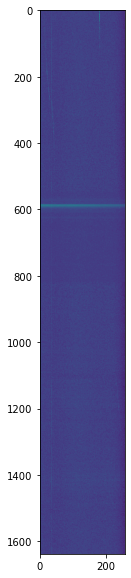

(1638, 256)


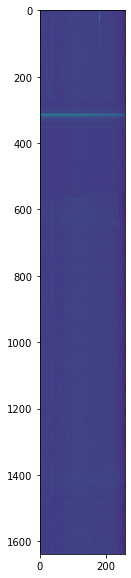

(1638, 256)


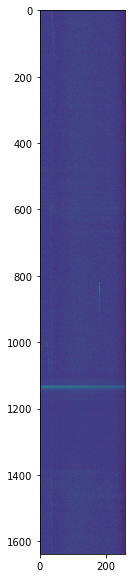

(768, 819, 3)


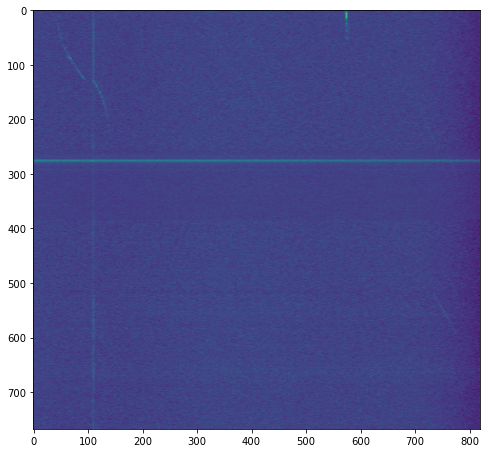

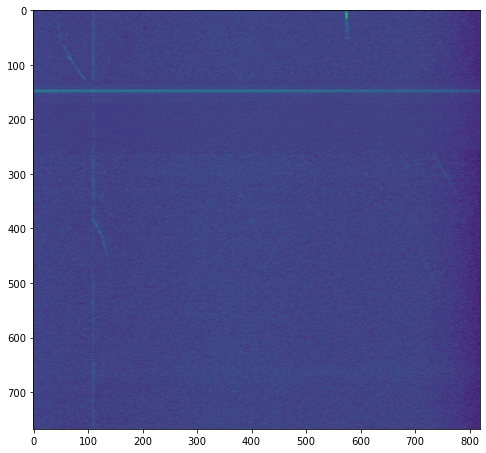

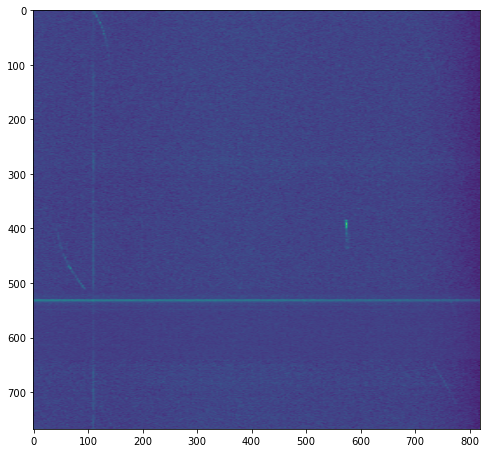

In [64]:
img = np.load(dict_paths_test['6d60c9cdef7ed60']).astype(np.float32)
img_norm, _ = normalizeImage(img, None)
print(img.shape)

img_size = (273*3, 256*3)

img_0 = np.vstack(img_norm)#.transpose((1, 0)).astype(np.float32)
print(img_0.shape)
plt.figure(figsize=(8, 10));plt.imshow(img_0);plt.show();

img_1 = np.vstack([img_norm[0], img_norm[2], img_norm[4], img_norm[1], img_norm[3], img_norm[5]])#.transpose((1, 0)).astype(np.float32)
print(img_1.shape)
plt.figure(figsize=(8, 10));plt.imshow(img_1);plt.show();

img_2 = np.vstack([img_norm[1], img_norm[3], img_norm[5], img_norm[0], img_norm[2], img_norm[4]])#.transpose((1, 0)).astype(np.float32)
print(img_2.shape)
plt.figure(figsize=(8, 10));plt.imshow(img_2);plt.show();

img_0 = cv2.resize(img_0, dsize=img_size)
img_1 = cv2.resize(img_1, dsize=img_size)
img_2 = cv2.resize(img_2, dsize=img_size)

img = np.stack([img_0, img_1, img_2], -1)
print(img.shape)
plt.figure(figsize=(8, 10));plt.imshow(img[:, :, 0]);plt.show();
plt.figure(figsize=(8, 10));plt.imshow(img[:, :, 1]);plt.show();
plt.figure(figsize=(8, 10));plt.imshow(img[:, :, 2]);plt.show();

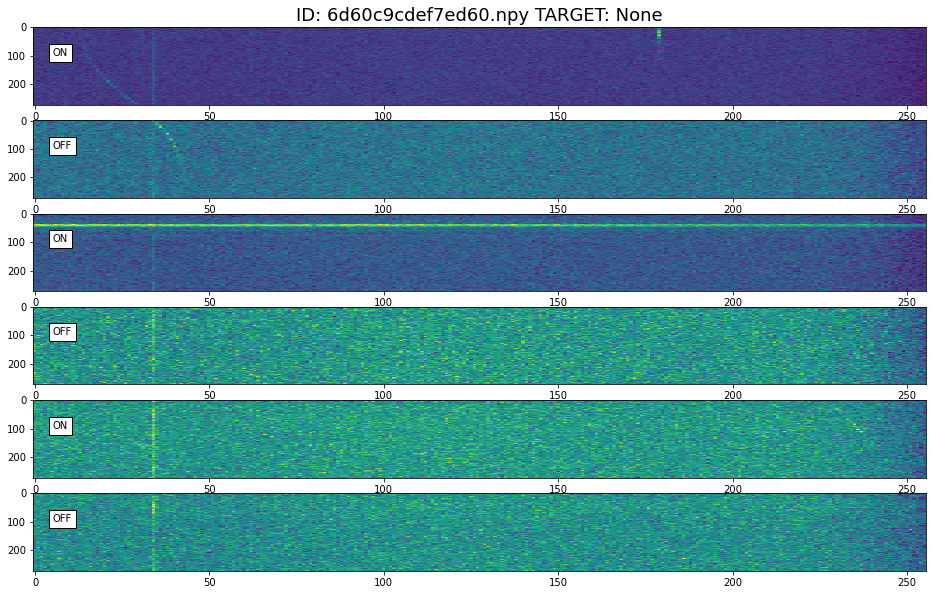

In [9]:
idx = dict_paths_test['6d60c9cdef7ed60']

plotCadence(idx, target=False)